In [ ]:
import torch
import torchvision

import torch.utils.tensorboard as tb
import numpy as np
import os

from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd

from torchvision.transforms import functional as TF

import torchvision.models as models
import torch.nn as nn
#change model here
resnet50 = models.vgg11(num_classes=4)

LABEL_NAMES = {'covid':0, 'normal':1,'pneumonia_bac':2,'pneumonia_vir':3}

LABEL_=['covid','normal','pneumonia_bac','pneumonia_vir']

## Reading Data

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')
 baseDir = '/content/drive/My Drive/GEOG788T/'

Mounted at /content/drive


In [ ]:
from PIL import Image
def is_jpg(filename):
    try:
        i=Image.open(filename)
        return True
    except IOError:
        return False

In [ ]:
is_jpg('/content/drive/My Drive/GEOG788T/train/pneumonia_vir/person80_virus_150.jpeg')

True

## Defining Torch Dataset

In [ ]:
gs = transforms.Grayscale(num_output_channels=3)
class SuperTuxDataset(Dataset):
    def __init__(self, image_path,data_transforms = transforms.ToTensor()):

        self.image_path = image_path
        if data_transforms==None:
          self.data_transforms = transforms.ToTensor()
        else:
          self.data_transforms = data_transforms

        img_list = []
        files = os.listdir(image_path+'covid')
        for file in files:
          if is_jpg(image_path+'covid/'+file)==True:
           img_list.append((file, 0))
        files = os.listdir(image_path+'normal')
        for file in files:
          if is_jpg(image_path+'normal/'+file)==True:
           img_list.append((file, 1))
        files = os.listdir(image_path+'pneumonia_bac')
        for file in files:
          if is_jpg(image_path+'pneumonia_bac/'+file)==True:
           img_list.append((file,2))
        files = os.listdir(image_path+'pneumonia_vir')
        for file in files:
          if is_jpg(image_path+'pneumonia_vir/'+file)==True:
           img_list.append((file,3))

        self.img_list = img_list


    def __len__(self):

        return len(self.img_list)


    def __getitem__(self, idx):

        img_name, img_label = self.img_list[idx]

        if img_label==0:
          img_path = self.image_path + 'covid/'+ img_name
        elif img_label==1:
          img_path = self.image_path + 'normal/'+ img_name
        elif img_label==2:
          img_path = self.image_path + 'pneumonia_bac/'+ img_name
        elif img_label==3:
          img_path = self.image_path + 'pneumonia_vir/'+ img_name
        img = Image.open(img_path)
        img = img.resize((150, 150))
        img = gs(img)


        img = self.data_transforms(img)
        img_dict={'image':img,'filename':img_name}



        return (img_dict,img_label)



In [ ]:
def visualize_data():

    Path_to_your_data= '/content/drive/My Drive/GEOG788T/train/'
    dataset = SuperTuxDataset(image_path=Path_to_your_data)

    f, axes = plt.subplots(3, len(LABEL_NAMES))

    counts = [0]*len(LABEL_NAMES)

    for img_dict, label in dataset:
        img=img_dict['image']
        c = counts[label]
        if c < 3:
            ax = axes[c][label]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.set_title(LABEL_[label])
            counts[label] += 1

        if sum(counts) >= 3 * len(LABEL_NAMES):
            break

    plt.show()

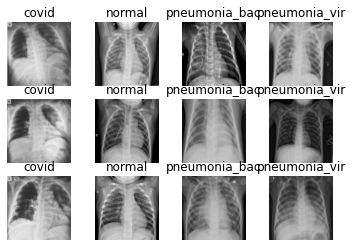

In [ ]:
visualize_data()

## Defining Model Architecture and Loss

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ClassificationLoss(torch.nn.Module):
    def forward(self, input, target):

        #import torch.nn.functional as F
        #loss=F.nll_loss(input,target)
        #return loss
        loss_f = nn.CrossEntropyLoss(reduction='mean')
        loss = loss_f(input, target)

        return loss

In [ ]:
from torch import save
from torch import load
from os import path
import torch.optim as optim
#change model here, change model file name
def save_model(model, num):
    return save(model.state_dict(), '/content/drive/My Drive/GEOG788T/two/'+'resnet50.th'+str(num))
def load_model(num):
    r = resnet50
    #r=r.load_state_dict(load(path.join(path.dirname(path.abspath('/content/two')), 'resnet50.th'+str(num)), map_location='cpu'))
    r.load_state_dict(torch.load('/content/drive/My Drive/GEOG788T/two/resnet50.th'+str(num)))


In [ ]:
from torch import save
from torch import load
from os import path
import torch.optim as optim
#change model here, change model file name
def save_model(model, num):
    return save(model.state_dict(), path.join(path.dirname(path.abspath('/content/two')), 'resnet50.th'+str(num)))
def load_model(num):
  r=resnet50
  r.load_state_dict(torch.load('/content/resnet50.th4'))

## Train

In [ ]:
def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

def predict(model, inputs, device='cpu'):
    inputs = inputs.to(device)
    logits = model(inputs)
    return F.softmax(logits, -1)
def draw_bar(axis, preds, labels=None):
    y_pos = np.arange(4)
    axis.barh(y_pos, preds, align='center', alpha=0.5)
    axis.set_xticks(np.linspace(0, 1, 10))

    if labels:
        axis.set_yticks(y_pos)
        axis.set_yticklabels(labels)
    else:
        axis.get_yaxis().set_visible(False)

    axis.get_xaxis().set_visible(False)

def visualize_predictions():

    model = load_model(37)
    model.eval()

    validation_image_path='/content/drive/My Drive/GEOG788T/test/' #enter the path

    dataset = SuperTuxDataset(image_path=validation_image_path)

    f, axes = plt.subplots(2, 6)

    idxes = np.random.randint(0, len(dataset), size=6)

    for i, idx in enumerate(idxes):
        img_dict, label = dataset[idx]
        img=img_dict['image']
        labelstr=str(label)
        img=img.resize(3,150,150)
        preds = predict(model, img[None], device='cpu').detach().cpu().numpy()
        img= img.to(torch.float32)

        axes[0, i].imshow(torchvision.transforms.functional.to_pil_image(img))
        axes[0, i].axis('off')
        #plt.title(labelstr)
        print(label)
        draw_bar(axes[1, i], preds[0], LABEL_ if i == 0 else None)

    plt.show()
def cal_accuracy(model_num, dataset, all_labels):
    model = load_model(model_num)
    model.eval()
    correct = 0
    for i in range(len(dataset)):
      img_dict, label = dataset[i]
      img=img_dict['image']
      preds = predict(model, img[None], device='cpu').detach().cpu().numpy()
      l = np.argmax(preds)
      print(i)
      if all_labels[i] == l:
        correct+=1
      if i%5==0:
        print('finished: {}/{}'.format(i, len(dataset)), correct/(i+1))
    print('accuracy:', correct/len(dataset))
    return correct/len(dataset)

def learning_curve(num):
    all_labels = []
    image_path='/content/drive/My Drive/GEOG788T/train/'
    files = os.listdir(image_path+'covid')
    for file in files:
     if is_jpg(image_path+'covid/'+file)==True:
      all_labels.append(0)
    files = os.listdir(image_path+'normal')
    for file in files:
     if is_jpg(image_path+'normal/'+file)==True:
      all_labels.append(1)
    files = os.listdir(image_path+'pneumonia_bac')
    for file in files:
     if is_jpg(image_path+'pneumonia_bac/'+file)==True:
      all_labels.append(2)
    files = os.listdir(image_path+'pneumonia_vir')
    for file in files:
     if is_jpg(image_path+'pneumonia_vir/'+file)==True:
      all_labels.append(3)

    dataset = SuperTuxDataset(image_path=image_path)
    points = pd.DataFrame(columns=['epoch', 'Accuracy'])

    for i in range(num):
      accuracy = cal_accuracy(i, dataset, all_labels)
      points=points.append({'epoch': i, 'Accuracy': accuracy}, ignore_index=True)
    plt.plot('epoch', 'Accuracy', data=points, color='blue')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')



In [ ]:
visualize_predictions()

## Training models



In [ ]:
def load_data(dataset_path, data_transforms=None, num_workers=0, batch_size=1):
    dataset = SuperTuxDataset(dataset_path,data_transforms)
    return DataLoader(dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True)

In [ ]:
class Args(object):
  def __init__(self):
    self.learning_rate = 0.001
    self.epoch = 37
    self.momentum = 0.9
    self.log_dir = '/content/drive/My Drive/GEOG788T/log_dir2/'
    self.train_datapath ='/content/drive/My Drive/GEOG788T/train/'
    self.valid_datapath='/content/drive/My Drive/GEOG788T/test/'
    self.log_interval = 10

args = Args();


In [ ]:
def train(args):

    #change model here
    model = resnet50
   # model.cuda()
    model.train()


    train_loader = load_data(args.train_datapath, transforms.ToTensor(), 0, 1)
    test_loader=load_data(args.valid_datapath, transforms.ToTensor(), 0, 1)
    optimizer = optim.SGD(model.parameters(),
                          lr=args.learning_rate,
                          momentum=args.momentum)
    net_loss = ClassificationLoss()

    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(args.epoch + 1)]
    num_steps_per_epoch = len([i for i in range(len(train_loader)) if i%args.log_interval==0])

    stepper = 0

    if args.log_dir is not None:
        train_logger = tb.SummaryWriter(args.log_dir+ 'train')
        valid_logger = tb.SummaryWriter(args.log_dir+ 'valid')
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    for ep in range(args.epoch):

      for batch_idx, (data_dict, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data=data_dict['image']
        output = model.forward(data)
        loss = net_loss.forward(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            ep, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())

          train_logger.add_scalar('Train loss',loss.item(),(ep-1)*num_steps_per_epoch + stepper)

          train_counter.append(
            (batch_idx*64) + ((args.epoch-1)*len(train_loader.dataset)))
          torch.save(model.state_dict(), '/model.pth')
          torch.save(optimizer.state_dict(), '/optimizer.pth')
          stepper += 1
      device='cuda'
      train_accuracy=test(model,device,train_loader,ep)
      valid_accuracy=test(model,device,test_loader,ep)
      print('epoch:',ep,'train_acc:',train_accuracy,'valid_acc:',valid_accuracy)
      train_logger.add_scalar('train/accuracy',train_accuracy, global_step=ep)
      valid_logger.add_scalar('test/accuracy', valid_accuracy, global_step=ep)
      save_model(model, ep)
      scheduler.step()
    return model


In [ ]:
model=train(args)

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        #model.layer4 is the last layer of our network before the Global Average Pooling layer(last convolutional layer).
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
model_ft =resnet50
acts = LayerActivations(model_ft)

In [ ]:
loader = transforms.Compose([transforms.Resize((150,150)), transforms.ToTensor()])
def image_loader(image_name):
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image
image_path = ''
img = image_loader(image_path)
logps =  model_ft(img)
out_features = acts.features[0].squeeze(0)
out_features = np.transpose(out_features.detach(),(1,2,0))

In [ ]:
ps = torch.exp(logps)
pred = np.argmax(ps.cpu().detach())
W = model_ft.fc.weight
w = W[pred,:]

In [ ]:
cam = np.dot(out_features.detach(),w.detach().cpu())
class_activation = ndimg.zoom(cam, zoom=(32,32),order=1)
img = np.squeeze(img, axis=0)
img = np.transpose(img,(1,2,0))

plt.imshow(img, cmap='jet',alpha=1)
plt.imshow(class_activation,cmap='jet',alpha=0.5)

In [ ]:
learning_curve(37)

In [ ]:
def test(model,device,test1_loader,epoch):
  model.eval()
  test_loss=0
  correct=0
  column_names = ["filename", "pred"]
  df = pd.DataFrame(columns = column_names)
  with torch.no_grad():
    for data_dict,target in test1_loader:
      data=data_dict['image']
      filename=data_dict['filename']
      output=model(data)
      test_loss +=F.cross_entropy(output,target,reduction='sum').item()#sum up batch loss
      pred=output.argmax(dim=1,keepdim=True)#get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      df = df.append({'filename' : filename , 'pred' : pred} , ignore_index=True)
    df.to_pickle('/content/drive/My Drive/GEOG788T/'+'resnet_pred_'+str(epoch)+'.pkl')


  test_loss /=len(test1_loader.dataset)

  print('\nTest set: Average Loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n)'.format(
    test_loss,correct,len(test1_loader.dataset),100.*correct/len(test1_loader.dataset)))
  return correct/len(test1_loader.dataset)

In [ ]:
'/content/all/'+'pred_'+str(1)+'.xlsx'

'/content/all/pred_1.xlsx'

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter

import datetime
#logdir = "logs/scalars/" + datetime.date.today().strftime("%Y%m%d-%H%M%S")
logdir='/content/drive/My Drive/GEOG788T/log_dir2'
ROOT_LOG_DIR = './logdir'

In [ ]:
!rm -rf '/content/drive/My Drive/GEOG788T/log_dir2/train'

!rm -rf '/content/drive/My Drive/GEOG788T/log_dir2/valid'